#### Getting Started with FashionMNIST

This notebook shows how to load the FashionMNIST dataset in PyTorch and illustrates what kind of samples it contains.

In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
#from utils.dice_score import multiclass_dice_coeff, dice_coeff

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transformationen definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalisiert Daten auf [-1, 1]
])

# Erstellen Sie eine Instanz des Trainingssplits des FashionMNIST-Datasets
dataset_train = FashionMNIST(root='/data/FashionMNIST', train=True, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Jetzt erstellen Sie eine Instanz des Testsplits
dataset_valid = FashionMNIST(root='/data/FashionMNIST', train=False, download=True, 
                             transform=transform, target_transform=lambda x: torch.Tensor([x]).int())

# Für unsere Zwecke können wir die 60k Training- und 10k Testbeispiele kombinieren
from torch.utils.data import ConcatDataset
dataset = ConcatDataset([dataset_train, dataset_valid])

# Einige Informationen zum Datensatz anzeigen
print(f'The combined dataset contains {len(dataset)} samples.')
print(f'It contains objects from the following {len(dataset_train.classes)} classes:')
print(dataset_train.classes, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(dataset))
# 
img_tensor, class_label = dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=1024,
                                          shuffle=True, num_workers=2)

print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of a class label is:', class_label.shape)

The combined dataset contains 70000 samples.
It contains objects from the following 10 classes:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 

The shape of an image tensor is: torch.Size([1, 28, 28])
The shape of a class label is: torch.Size([1])


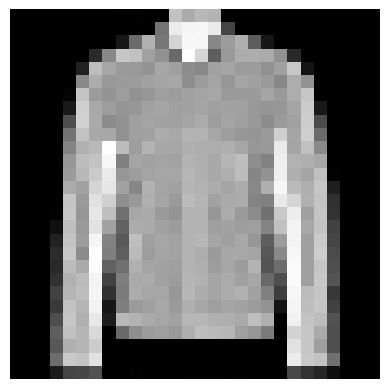

The image shows an instance of Coat.


In [3]:
# we can also visualize and describe a sample
fig, ax = plt.subplots()
ax.imshow(img_tensor.cpu().squeeze(), cmap='Greys_r')
plt.axis('off')
plt.show()
print('The image shows an instance of ' + dataset_train.classes[class_label.item()] + '.')

In [4]:
min_value = torch.min(img_tensor)
max_value = torch.max(img_tensor)

print(f"Minimaler Wert: {min_value.item()}")
print(f"Maximaler Wert: {max_value.item()}")



Minimaler Wert: -1.0
Maximaler Wert: 1.0


In [5]:
# handvoll resisdual basic blocks -> flatten -> handvoll fully conntected layers
# resnet basic block : conv3x3 + norm_layer + non_lin + conv3x3 + normlayer
# identity: conv1x1 + norm layer
# output: non_lin(identity_layers(x) + [conv3x3 + norm_layer + non_lin + conv3x3 + normlayer](x))

In [6]:
def create_linear_schedule(steps, start, end):
    step_size = (end - start) / (steps - 1)  
    linear_schedule = []
    for i in range(steps):
        linear_schedule.append(start + i * step_size)
    return linear_schedule



In [7]:
def normalize_image(image):
    min_value = torch.min(image)
    max_value = torch.max(image)
    
    normalized_image = 2 * ((image - min_value) / (max_value - min_value)) - 1
    return normalized_image

In [8]:
# Function to add Gaussian noise to an image tensor
def add_gaussian_noise(image, mean=0., std=1.):
    eps = torch.empty_like(image).normal_(mean=0,std=1)
    noise = eps * std + mean
    # beta*eps + sqrt(1-beta)*image+std # (1-beta).sqrt()*image + beta*eps
    # Clip the values to be between 0 and 1
    # noisy_image = normalize_image(noisy_image)
    return noise, eps

In [9]:
def one_forward_step(curr_image, beta):
    std = np.sqrt(beta) #* np.random.normal()#* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(1-beta) * curr_image #+ std
    image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return image

In [10]:
def mache_noise(image, anzahl_bilder):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    # Display the original image
    plt.imshow(image.cpu().squeeze())
    plt.title("Original Image")
    plt.show()
    
    verrauschte_bilder = []
    schedule = create_linear_schedule(anzahl_bilder, 0.0001, 0.02)
    print(schedule)
    noisy_image_tensor = image
    for i in range(len(schedule)):
        noisy_image_tensor = one_forward_step(noisy_image_tensor, schedule[i])
        
        # Convert the noisy image tensor back to a PIL image
        noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
        
        verrauschte_bilder.append(noisy_image)
        
        # Optional: Display each noisy image if desired
        plt.imshow(noisy_image, cmap='Greys_r')
        plt.title(f"Noisy Image {i+1}: {noisy_image_tensor.mean()}, {noisy_image_tensor.std()}")
        plt.show()
    

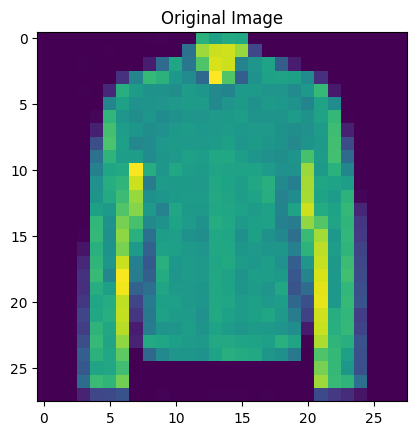

[0.0001, 0.0050750000000000005, 0.01005, 0.015025, 0.02]


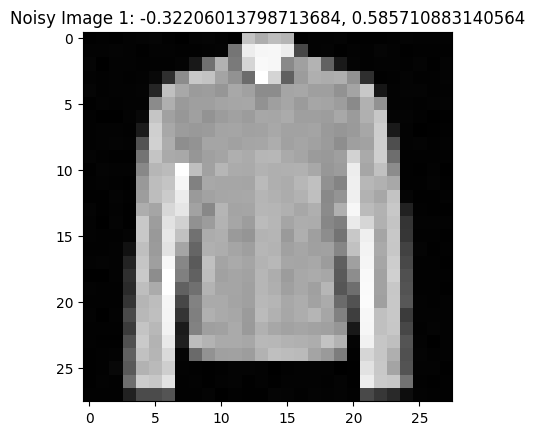

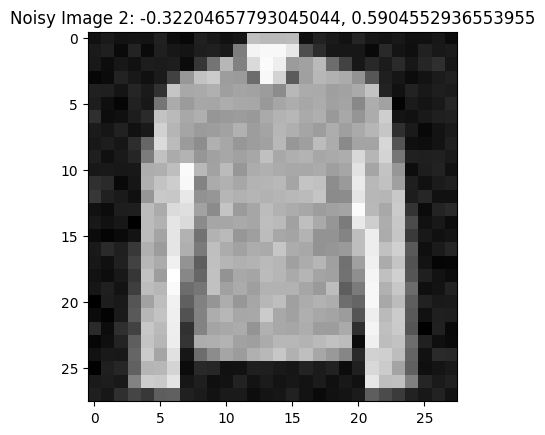

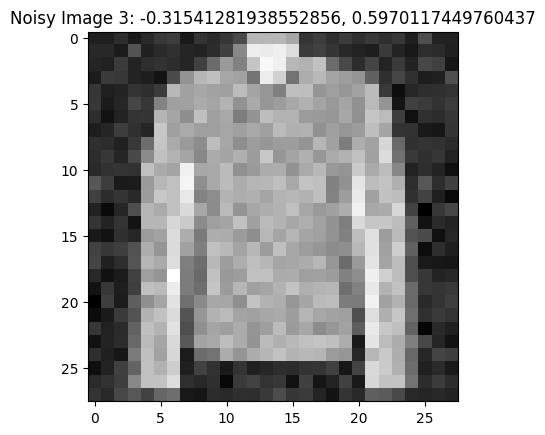

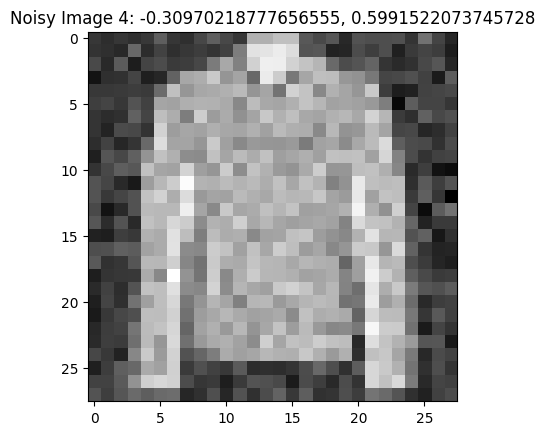

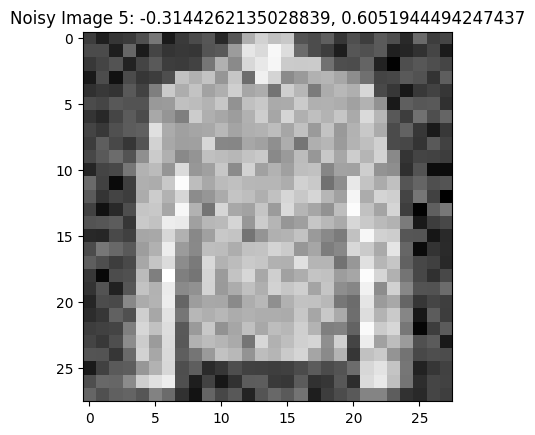

In [11]:
img_tensor = img_tensor.to(device)
mache_noise(img_tensor, 5)

In [12]:
def berechne_alpha_quer_x_forward_steps(anzahl_steps):
    scheduler = create_linear_schedule(anzahl_steps, 0.0001, 0.02)
    alphas = 1 - np.array(scheduler)
    alphas_quer = []
    for i in range(len(alphas)):
        alphas_quer.append(np.prod(alphas[:i + 1]))
    return alphas_quer

In [13]:
def x_forward_steps(curr_image, alpha_quer):
    std = np.sqrt(1 - alpha_quer) #* np.identity(like=curr_image) Nicht notwendig da äquivalent zu Skalar von Rechts
    mean = np.sqrt(alpha_quer) * curr_image
    new_image, eps = add_gaussian_noise(curr_image,mean=mean,std=std)
    return new_image, eps

In [14]:
def mache_noise_direkt(image, anzahl_steps, total_steps=1000):
    # Convert the image to a PyTorch tensor
    # transform = transforms.ToTensor()
    # image_tensor = transform(image)
    
    noisy_image_tensor = image
    
    alpha_quer = berechne_alpha_quer_x_forward_steps(total_steps)
    
    noisy_image_tensor, eps = x_forward_steps(noisy_image_tensor, alpha_quer[anzahl_steps-1])
    noisy_image = ((noisy_image_tensor/2)+0.5).cpu().squeeze()
    
    return noisy_image_tensor, eps


In [15]:

mache_noise_direkt(img_tensor, 4, 5)

(tensor([[[-1.0020e+00, -9.2652e-01, -1.2560e+00, -1.1884e+00, -6.3699e-01,
           -1.1754e+00, -1.0685e+00, -9.8547e-01, -1.0705e+00, -8.8628e-01,
           -1.1763e+00, -9.6996e-01,  1.8770e-03, -1.1570e-01,  3.4719e-02,
            9.6127e-02, -5.9197e-01, -1.1509e+00, -1.0364e+00, -9.9674e-01,
           -7.4480e-01, -6.3615e-01, -1.0893e+00, -8.5904e-01, -1.1234e+00,
           -8.8204e-01, -1.1333e+00, -1.0947e+00],
          [-8.7301e-01, -7.3239e-01, -1.1123e+00, -1.0012e+00, -8.6222e-01,
           -8.7326e-01, -9.6059e-01, -1.0737e+00, -6.9509e-01, -7.9734e-01,
           -1.0376e+00, -8.1446e-02,  5.0828e-01,  8.4727e-01,  8.9625e-01,
            7.5894e-01, -6.3005e-01, -1.0065e+00, -9.0124e-01, -9.6944e-01,
           -6.1490e-01, -8.7431e-01, -9.0798e-01, -6.8704e-01, -1.0585e+00,
           -1.0436e+00, -1.1701e+00, -9.5219e-01],
          [-1.1291e+00, -1.0301e+00, -1.3564e+00, -1.0874e+00, -1.0835e+00,
           -7.5642e-01, -7.7440e-01, -1.0126e+00, -5.8334e-01,

In [16]:
# U-net architecture: Eingabe (Bild) -> Ausgabe (Segmentation map)

In [17]:
import torch.nn as nn

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


In [18]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [19]:
# Comments inspired from https://distill.pub/2016/deconv-checkerboard/

#Stride 1 deconvolutions — which we often see as the last layer in successful models 
#(eg. [2])  — are quite effective at dampening artifacts. 
#In particular, deconvolution has uneven overlap when the kernel size 
#(the output window size) is not divisible by the stride (the spacing between points on the top).

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        #Another approach is to separate out upsampling to a higher resolution from convolution to compute features.
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        #Diese Zeilen berechnen die Größenunterschiede
        #in den Höhen- und Breitenrichtungen zwischen x2 und dem upgesampleten x1.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        #Diese Zeile fügt x1 an den Rändern Polster hinzu, 
        #sodass es die gleiche räumliche Größe wie x2 hat. Das 
        #Padding sorgt dafür, dass die beiden Feature-Maps aneinander angehängt werden können.

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [20]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [21]:
def get_sinusoid_encoding_table(n_position, d_hid):
    ''' Sinusoid position encoding table '''

    def get_position_angle_vec(position):
        return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

    sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

    return torch.FloatTensor(sinusoid_table)#.unsqueeze(0)

In [22]:
def concat_pos_param(x, enc):
    pos_enc_reshape = enc.reshape(1,-1,1,1).expand((x.shape[0],-1,x.shape[2],x.shape[3]))
    feature_map_with_encoding = torch.cat([x, pos_enc_reshape], dim=1)
    return feature_map_with_encoding

In [23]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, t_max=1000, d_hid=32):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        factor = 2
        self.pos_enc = get_sinusoid_encoding_table(t_max, d_hid)#nn.Parameter(get_sinusoid_encoding_table(t_max, d_hid), requires_grad=False)
        self.pos_enc.requires_grad = False 
        self.inc = (DoubleConv(n_channels + d_hid, 64))
        self.down1 = (Down(64 + d_hid, 128))
        self.down2 = (Down(128 + d_hid, 256 // factor))
        #self.down3 = (Down(256, 512))
        #self.down4 = (Down(512, 1024 // factor))
        #self.up1 = (Up(1024, 512 // factor))
        #self.up2 = (Up(512, 256 // factor))
        self.up3 = (Up(256, 128 // factor))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_channels))

    def forward(self, x, t):
        enc = self.pos_enc[t]
        
        x1 = self.inc(concat_pos_param(x, enc))
        x2 = self.down1(concat_pos_param(x1, enc))
        x3 = self.down2(concat_pos_param(x2, enc))
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits
    

In [24]:
unet = UNet(1,100)
dataiter = iter(trainloader)
i, data = next(dataiter)


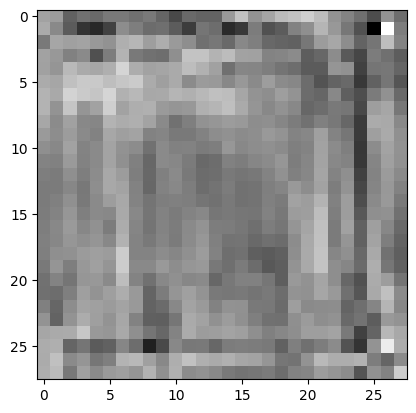

In [25]:
for j in range(1):
    img = unet(i, 5).detach().numpy()[0, j, :, :]
    plt.imshow(img, cmap='gray')  # `cmap='gray'` wird verwendet, da es sich um ein Graustufenbild handelt
    plt.show()

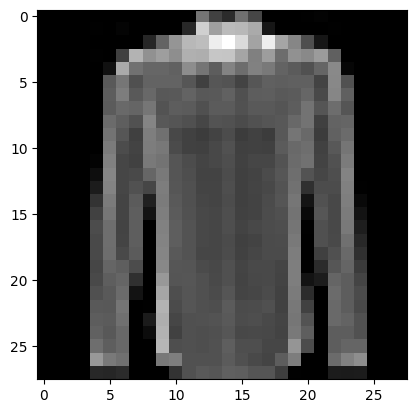

In [26]:
plt.imshow(i[0, 0, :, :], cmap='gray')
plt.show()


In [27]:
learning_rate = 0.002
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=learning_rate, weight_decay = 0.001)

def evaluate(net, dataloader, device):
    net.eval()
    num_val_batches = len(dataloader)
    

    
    progress_bar = tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False)
    for batch in progress_bar:
        image, mask_true = batch[0], batch[1]

            # move images and labels to correct device and type
        image = image.to(dtype=torch.float32, memory_format=torch.channels_last).cpu()
        t = np.random.randint(1000)
        noisy_image, eps = mache_noise_direkt(image, t)
        mask_true = mask_true.to(dtype=torch.long).cpu()
        
        mask_pred = net(noisy_image.cpu(),t)
        
        loss = criterion(mask_pred, eps)
        print(loss.item())
        


    net.train()
    return 

In [28]:
def train_model(
        model,
        device,
        epochs: int = 2,
        batch_size: int = 2048,
        learning_rate: float = 1e-4,
        val_percent: float = 0.1,
        img_scale: float = 0.5,
        weight_decay: float = 1e-8,
        gradient_clipping: float = 1.0,
):
    
    
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)
    for epoch in progress_bar:
        model.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader):
            image, mask_true = data
            progress_bar.set_postfix({f'T of {[len(trainloader)]}' : i+1}, refresh=True)
            optimizer.zero_grad()
                # move images and labels to correct device and type
            image = image.to(dtype=torch.float32, memory_format=torch.channels_last).cpu()
            t = 50
            noisy_image, eps = mache_noise_direkt(image, t)
            mask_true = mask_true.to(dtype=torch.long).cpu()

            mask_pred = model(noisy_image.cpu(),t)

            loss = criterion(mask_pred, eps)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i%2==0:
                print(f'[{epoch + 1}, {i + 1:5d}] running_loss: {running_loss / 10:.3f}, ')
                running_loss = 0.0
                
    evaluate(model, trainloader, device) # TODO: hier noch valloader erstellen.


In [29]:
train_model(unet, device)

  0%|                                                                                                                                                                                                                                                                                      | 0/2 [00:05<?, ?it/s, T of [59]=2]

[1,     1] running_loss: 0.112, 


  0%|                                                                                                                                                                                                                                                                                      | 0/2 [00:16<?, ?it/s, T of [59]=4]

[1,     3] running_loss: 0.245, 


  0%|                                                                                                                                                                                                                                                                                      | 0/2 [00:27<?, ?it/s, T of [59]=6]

[1,     5] running_loss: 0.169, 


  0%|                                                                                                                                                                                                                                                                                      | 0/2 [00:37<?, ?it/s, T of [59]=8]

[1,     7] running_loss: 0.133, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [00:48<?, ?it/s, T of [59]=10]

[1,     9] running_loss: 0.111, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [00:58<?, ?it/s, T of [59]=12]

[1,    11] running_loss: 0.097, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [01:09<?, ?it/s, T of [59]=14]

[1,    13] running_loss: 0.087, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [01:20<?, ?it/s, T of [59]=16]

[1,    15] running_loss: 0.077, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [01:33<?, ?it/s, T of [59]=18]

[1,    17] running_loss: 0.072, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [01:45<?, ?it/s, T of [59]=20]

[1,    19] running_loss: 0.070, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [01:55<?, ?it/s, T of [59]=22]

[1,    21] running_loss: 0.067, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:06<?, ?it/s, T of [59]=24]

[1,    23] running_loss: 0.063, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:16<?, ?it/s, T of [59]=26]

[1,    25] running_loss: 0.061, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:27<?, ?it/s, T of [59]=28]

[1,    27] running_loss: 0.060, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:37<?, ?it/s, T of [59]=30]

[1,    29] running_loss: 0.058, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:48<?, ?it/s, T of [59]=32]

[1,    31] running_loss: 0.057, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [02:58<?, ?it/s, T of [59]=34]

[1,    33] running_loss: 0.056, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [03:09<?, ?it/s, T of [59]=36]

[1,    35] running_loss: 0.054, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [03:19<?, ?it/s, T of [59]=38]

[1,    37] running_loss: 0.054, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [03:30<?, ?it/s, T of [59]=40]

[1,    39] running_loss: 0.052, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [03:40<?, ?it/s, T of [59]=42]

[1,    41] running_loss: 0.052, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [03:51<?, ?it/s, T of [59]=44]

[1,    43] running_loss: 0.052, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:01<?, ?it/s, T of [59]=46]

[1,    45] running_loss: 0.051, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:12<?, ?it/s, T of [59]=48]

[1,    47] running_loss: 0.050, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:22<?, ?it/s, T of [59]=50]

[1,    49] running_loss: 0.049, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:33<?, ?it/s, T of [59]=52]

[1,    51] running_loss: 0.048, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:43<?, ?it/s, T of [59]=54]

[1,    53] running_loss: 0.049, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [04:54<?, ?it/s, T of [59]=56]

[1,    55] running_loss: 0.049, 


  0%|                                                                                                                                                                                                                                                                                     | 0/2 [05:04<?, ?it/s, T of [59]=58]

[1,    57] running_loss: 0.048, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [05:13<05:13, 313.31s/it, T of [59]=59]

[1,    59] running_loss: 0.047, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1/2 [05:19<05:13, 313.31s/it, T of [59]=2]

[2,     1] running_loss: 0.024, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1/2 [05:29<05:13, 313.31s/it, T of [59]=4]

[2,     3] running_loss: 0.047, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1/2 [05:40<05:13, 313.31s/it, T of [59]=6]

[2,     5] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                      | 1/2 [05:50<05:13, 313.31s/it, T of [59]=8]

[2,     7] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:01<05:13, 313.31s/it, T of [59]=10]

[2,     9] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:11<05:13, 313.31s/it, T of [59]=12]

[2,    11] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:22<05:13, 313.31s/it, T of [59]=14]

[2,    13] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:32<05:13, 313.31s/it, T of [59]=16]

[2,    15] running_loss: 0.045, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:43<05:13, 313.31s/it, T of [59]=18]

[2,    17] running_loss: 0.045, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [06:53<05:13, 313.31s/it, T of [59]=20]

[2,    19] running_loss: 0.045, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:04<05:13, 313.31s/it, T of [59]=22]

[2,    21] running_loss: 0.045, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:14<05:13, 313.31s/it, T of [59]=24]

[2,    23] running_loss: 0.046, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:25<05:13, 313.31s/it, T of [59]=26]

[2,    25] running_loss: 0.045, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:35<05:13, 313.31s/it, T of [59]=28]

[2,    27] running_loss: 0.044, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:46<05:13, 313.31s/it, T of [59]=30]

[2,    29] running_loss: 0.044, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [07:56<05:13, 313.31s/it, T of [59]=32]

[2,    31] running_loss: 0.044, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:07<05:13, 313.31s/it, T of [59]=34]

[2,    33] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:17<05:13, 313.31s/it, T of [59]=36]

[2,    35] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:28<05:13, 313.31s/it, T of [59]=38]

[2,    37] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:38<05:13, 313.31s/it, T of [59]=40]

[2,    39] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:49<05:13, 313.31s/it, T of [59]=42]

[2,    41] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [08:59<05:13, 313.31s/it, T of [59]=44]

[2,    43] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [09:10<05:13, 313.31s/it, T of [59]=46]

[2,    45] running_loss: 0.042, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [09:20<05:13, 313.31s/it, T of [59]=48]

[2,    47] running_loss: 0.042, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [09:31<05:13, 313.31s/it, T of [59]=50]

[2,    49] running_loss: 0.042, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [09:41<05:13, 313.31s/it, T of [59]=52]

[2,    51] running_loss: 0.042, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [09:52<05:13, 313.31s/it, T of [59]=54]

[2,    53] running_loss: 0.043, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [10:02<05:13, 313.31s/it, T of [59]=56]

[2,    55] running_loss: 0.042, 


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 1/2 [10:13<05:13, 313.31s/it, T of [59]=58]

[2,    57] running_loss: 0.042, 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [10:21<00:00, 310.74s/it, T of [59]=59]


[2,    59] running_loss: 0.042, 


Validation round:   2%|████▍                                                                                                                                                                                                                                                                | 1/59 [00:02<02:07,  2.20s/batch]

8.31421184539795


Validation round:   3%|████████▊                                                                                                                                                                                                                                                            | 2/59 [00:04<01:57,  2.06s/batch]

6.759269714355469


Validation round:   5%|█████████████▎                                                                                                                                                                                                                                                       | 3/59 [00:06<01:52,  2.01s/batch]

1.8928465843200684


Validation round:   7%|█████████████████▋                                                                                                                                                                                                                                                   | 4/59 [00:08<01:48,  1.98s/batch]

4.518887042999268


Validation round:   8%|██████████████████████                                                                                                                                                                                                                                               | 5/59 [00:09<01:46,  1.97s/batch]

2.8949222564697266


Validation round:  10%|██████████████████████████▌                                                                                                                                                                                                                                          | 6/59 [00:11<01:44,  1.97s/batch]

9.763001441955566


Validation round:  12%|██████████████████████████████▉                                                                                                                                                                                                                                      | 7/59 [00:13<01:43,  1.98s/batch]

8.89982795715332


Validation round:  14%|███████████████████████████████████▍                                                                                                                                                                                                                                 | 8/59 [00:15<01:40,  1.97s/batch]

1.1620181798934937


Validation round:  15%|███████████████████████████████████████▊                                                                                                                                                                                                                             | 9/59 [00:17<01:38,  1.96s/batch]

1.8624099493026733


Validation round:  17%|████████████████████████████████████████████                                                                                                                                                                                                                        | 10/59 [00:19<01:36,  1.96s/batch]

0.2987539768218994


Validation round:  19%|████████████████████████████████████████████████▍                                                                                                                                                                                                                   | 11/59 [00:21<01:33,  1.96s/batch]

2.5060818195343018


Validation round:  20%|████████████████████████████████████████████████████▉                                                                                                                                                                                                               | 12/59 [00:23<01:32,  1.96s/batch]

14.737732887268066


Validation round:  22%|█████████████████████████████████████████████████████████▎                                                                                                                                                                                                          | 13/59 [00:25<01:30,  1.96s/batch]

7.4947590827941895


Validation round:  24%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                                                      | 14/59 [00:27<01:28,  1.96s/batch]

7.000495910644531


Validation round:  25%|██████████████████████████████████████████████████████████████████                                                                                                                                                                                                  | 15/59 [00:29<01:25,  1.95s/batch]

3.140324831008911


Validation round:  27%|██████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                             | 16/59 [00:31<01:23,  1.95s/batch]

4.157486438751221


Validation round:  29%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                         | 17/59 [00:33<01:21,  1.95s/batch]

6.229341983795166


Validation round:  31%|███████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                                                    | 18/59 [00:35<01:19,  1.95s/batch]

6.002020359039307


Validation round:  32%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                                                | 19/59 [00:37<01:17,  1.95s/batch]

11.793384552001953


Validation round:  34%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                           | 20/59 [00:39<01:19,  2.05s/batch]

6.874987602233887


Validation round:  36%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                       | 21/59 [00:41<01:18,  2.06s/batch]

5.5769267082214355


Validation round:  37%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 22/59 [00:43<01:15,  2.03s/batch]

2.708632469177246


Validation round:  39%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                              | 23/59 [00:45<01:12,  2.01s/batch]

3.8675930500030518


Validation round:  41%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 24/59 [00:47<01:09,  1.99s/batch]

8.813590049743652


Validation round:  42%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                     | 25/59 [00:49<01:07,  1.98s/batch]

6.613297939300537


Validation round:  44%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                 | 26/59 [00:51<01:04,  1.97s/batch]

4.099560260772705


Validation round:  46%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                             | 27/59 [00:53<01:03,  1.99s/batch]

4.168717384338379


Validation round:  47%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                        | 28/59 [00:55<01:01,  1.99s/batch]

5.6032395362854


Validation round:  49%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                    | 29/59 [00:57<00:59,  1.98s/batch]

8.784313201904297


Validation round:  51%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                               | 30/59 [00:59<00:57,  1.97s/batch]

8.367844581604004


Validation round:  53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                           | 31/59 [01:01<00:55,  1.97s/batch]

1.1427099704742432


Validation round:  54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                       | 32/59 [01:03<00:53,  1.97s/batch]

4.876703262329102


Validation round:  56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                  | 33/59 [01:05<00:51,  1.96s/batch]

6.120493412017822


Validation round:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                              | 34/59 [01:07<00:48,  1.95s/batch]

13.195202827453613


Validation round:  59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 35/59 [01:09<00:47,  1.96s/batch]

6.522655487060547


Validation round:  61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 36/59 [01:11<00:44,  1.95s/batch]

7.376358985900879


Validation round:  63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                 | 37/59 [01:13<00:43,  1.96s/batch]

6.351638317108154


Validation round:  64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                            | 38/59 [01:15<00:41,  1.97s/batch]

4.720199108123779


Validation round:  66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 39/59 [01:17<00:39,  1.98s/batch]

19.491744995117188


Validation round:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 40/59 [01:19<00:37,  1.97s/batch]

1.8729621171951294


Validation round:  69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 41/59 [01:21<00:35,  1.97s/batch]

7.964080333709717


Validation round:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                           | 42/59 [01:23<00:33,  1.97s/batch]

9.555253982543945


Validation round:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 43/59 [01:25<00:31,  1.97s/batch]

2.4407219886779785


Validation round:  75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 44/59 [01:26<00:29,  1.96s/batch]

5.871258735656738


Validation round:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 45/59 [01:28<00:27,  1.96s/batch]

12.333704948425293


Validation round:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 46/59 [01:30<00:25,  1.96s/batch]

2.8221395015716553


Validation round:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 47/59 [01:32<00:23,  1.96s/batch]

2.331139326095581


Validation round:  81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 48/59 [01:34<00:21,  1.96s/batch]

15.198742866516113


Validation round:  83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 49/59 [01:36<00:19,  1.97s/batch]

3.356174945831299


Validation round:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 50/59 [01:38<00:17,  1.96s/batch]

4.834756851196289


Validation round:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 51/59 [01:40<00:15,  1.96s/batch]

8.422989845275879


Validation round:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 52/59 [01:42<00:13,  1.95s/batch]

2.9793426990509033


Validation round:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 53/59 [01:44<00:11,  1.96s/batch]

5.467329978942871


Validation round:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 54/59 [01:46<00:09,  1.97s/batch]

3.696103572845459


Validation round:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 55/59 [01:48<00:07,  1.96s/batch]

3.218637466430664


Validation round:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 56/59 [01:50<00:05,  1.93s/batch]

5.596401691436768


Validation round:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 57/59 [01:52<00:03,  1.92s/batch]

1.1526148319244385


Validation round:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 58/59 [01:54<00:01,  1.91s/batch]

16.31546401977539


17.959760665893555


In [31]:
def try_to_revert(noise, eps, anzahl_schritte, total_schritte=1000):
    alpha_quers = berechne_alpha_quer_x_forward_steps(total_schritte)
    return (noise - eps * np.sqrt(1-alpha_quers[anzahl_schritte - 1]))/np.sqrt(alpha_quers[anzahl_schritte - 1])
    

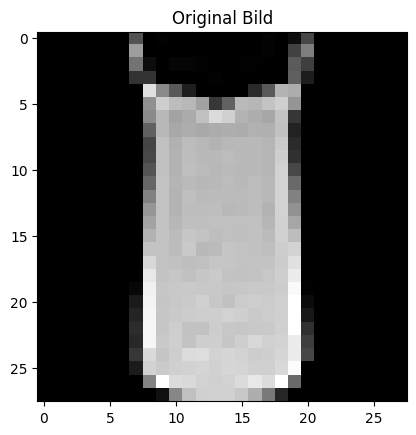

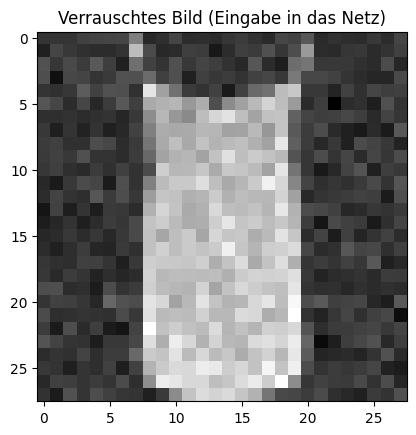

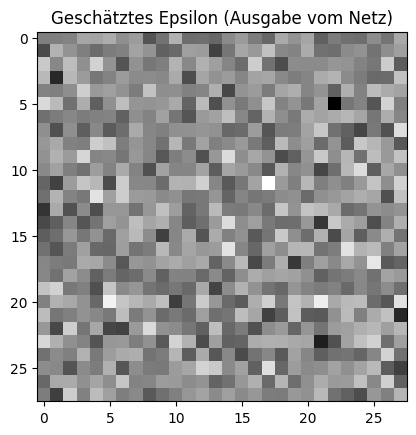

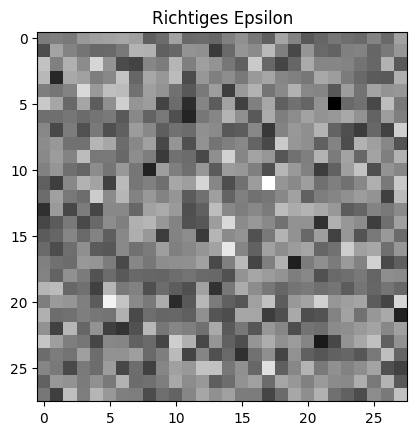

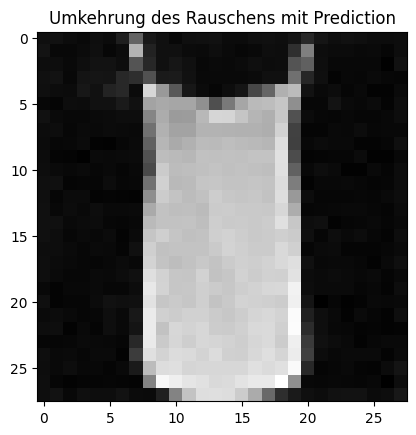

In [41]:
dataiter = iter(trainloader)
i, data = next(dataiter)

plt.imshow(i[0,0].detach().numpy(), cmap="gray")
plt.title("Original Bild")
plt.show()

img_noise, eps = mache_noise_direkt(i[0:1], 50)

plt.imshow(img_noise[0,0].detach().numpy(), cmap="gray")
plt.title("Verrauschtes Bild (Eingabe in das Netz)")
plt.show()

img_pred = unet(img_noise, 50)



plt.imshow(img_pred[0,0].detach().numpy(), cmap="gray")
plt.title("Geschätztes Epsilon (Ausgabe vom Netz)")
plt.show()



plt.imshow(eps[0,0].detach().numpy(), cmap="gray")
plt.title("Richtiges Epsilon")
plt.show()

reverted_img = try_to_revert(img_noise, img_pred, 50)

plt.imshow(reverted_img[0,0].detach().numpy(), cmap="gray")
plt.title("Umkehrung des Rauschens mit Prediction")
plt.show()

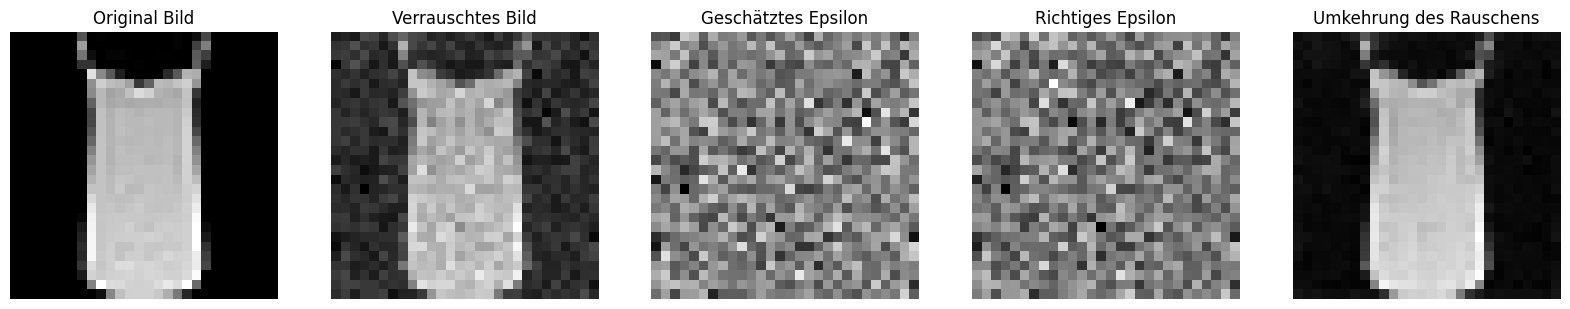

In [44]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1 Reihe, 5 Spalten

# Original Bild
axs[0].imshow(i[0, 0].detach().numpy(), cmap="gray")
axs[0].set_title("Original Bild")
axs[0].axis('off')

# Verrauschtes Bild
img_noise, eps = mache_noise_direkt(i[0:1], 50)
axs[1].imshow(img_noise[0, 0].detach().numpy(), cmap="gray")
axs[1].set_title("Verrauschtes Bild")
axs[1].axis('off')

# Geschätztes Epsilon
img_pred = unet(img_noise, 50)
axs[2].imshow(img_pred[0, 0].detach().numpy(), cmap="gray")
axs[2].set_title("Geschätztes Epsilon")
axs[2].axis('off')

# Richtiges Epsilon
axs[3].imshow(eps[0, 0].detach().numpy(), cmap="gray")
axs[3].set_title("Richtiges Epsilon")
axs[3].axis('off')

# Umkehrung des Rauschens
reverted_img = try_to_revert(img_noise, img_pred, 50)
axs[4].imshow(reverted_img[0, 0].detach().numpy(), cmap="gray")
axs[4].set_title("Umkehrung des Rauschens")
axs[4].axis('off')

plt.show()


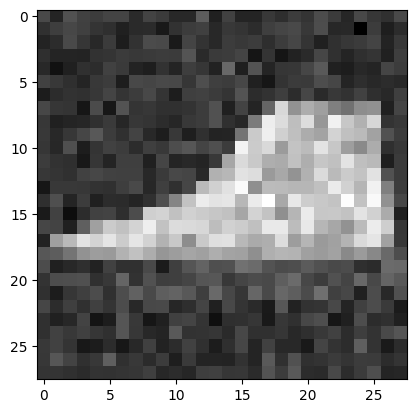

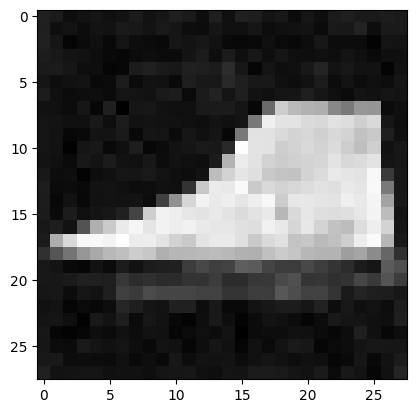

In [35]:
plt.imshow(img_noise[0,0].detach().numpy(), cmap="gray")
plt.show()

plt.imshow(reverted_img[0,0].detach().numpy(), cmap="gray")
plt.show()

torch.Size([1, 1, 28, 28])


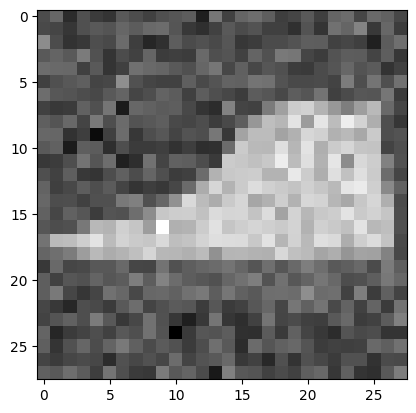

In [36]:
betas = create_linear_schedule(1000, 0.0001, 0.02)
alphas = 1 - np.array(betas)
alphas_quer = []
for i in range(len(alphas)):
    alphas_quer.append(np.prod(alphas[:i + 1]))

for i in reversed(range(50)):
    if i > 1:
        z = torch.randn_like(img_noise)
    else:
        z = torch.zeros_like(img_noise)
        
    img_noise = (1/np.sqrt(alphas[i+1])) * (img_noise - (1- alphas[i+1])/(np.sqrt(1-alphas_quer[i+1])) * img_pred) + z*np.sqrt((1-alphas_quer[i])/(1-alphas_quer[i+1]) * betas[i+1])
    
print(img_noise.shape)
plt.imshow(img_noise[0,0].detach().numpy(), cmap="gray")
plt.show()

In [ ]:
plt.imshow(img_noise[0,0].detach().numpy(), cmap="gray")
plt.show()
